In [21]:
%matplotlib inline
from pyiem.util import get_dbconn
from shapely.wkt import loads

POSTGIS = get_dbconn('postgis')
cursor = POSTGIS.cursor()

roads = []
freq = []

cursor.execute("""
WITH obs as (
 SELECT segid, sum(lead - valid) from
 (SELECT segid, valid,  lead(valid) OVER (PARTITION by segid ORDER by valid ASC),
 cond_code from roads_2017_2018_log WHERE valid > '2017-11-01') as foo
 WHERE cond_code > 0 GROUP by segid
)
 SELECT obs.sum, ST_AsEWKT(ST_Transform(base.simple_geom,4326)) from obs JOIN
 roads_base base on (obs.segid = base.segid) 

""")

for row in cursor:
    if row[1] is None:
        continue
    roads.append(loads(row[1][10:]))
    freq.append(row[0])
print(len(freq))

686


In [22]:
import datetime

sts = datetime.datetime(2017,12,1)
ets = datetime.datetime(2017,12,21,19)
period = (ets - sts).total_seconds()

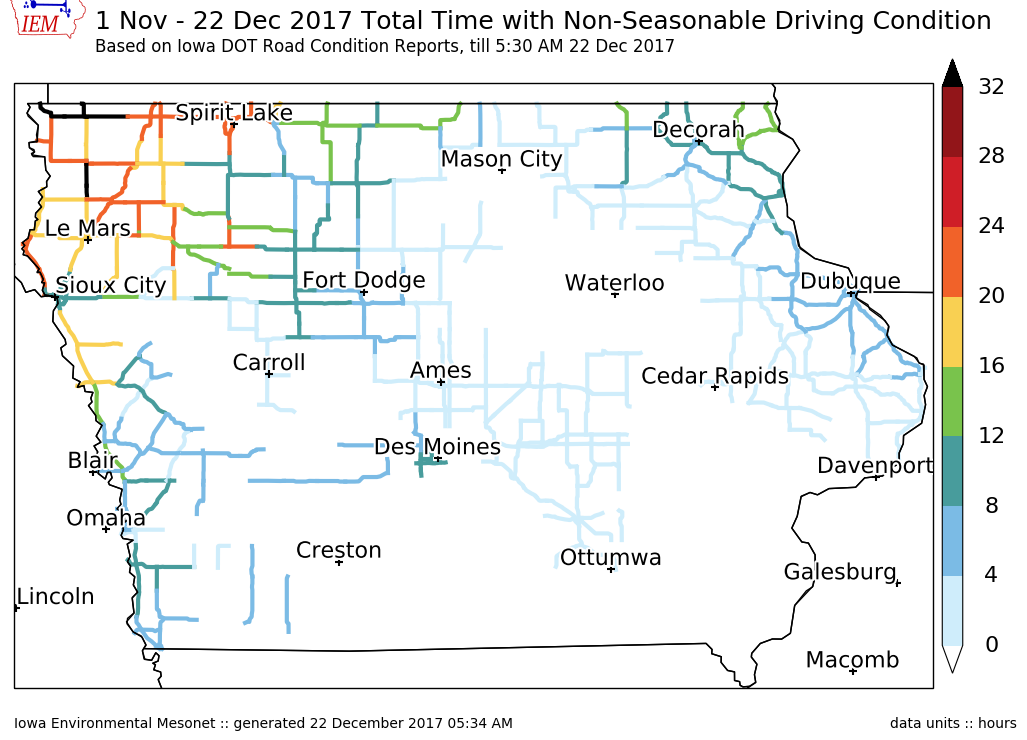

In [23]:
from pyiem.plot import MapPlot, whitebluegreenyellowred
import numpy as np
import matplotlib.colors as mpcolors
import cartopy.crs as ccrs

cmap = whitebluegreenyellowred()
clevs = np.arange(0,33,4)
norm = mpcolors.BoundaryNorm(clevs, cmap.N)

m = MapPlot(title='1 Nov - 22 Dec 2017 Total Time with Non-Seasonable Driving Condition',
            subtitle='Based on Iowa DOT Road Condition Reports, till 5:30 AM 22 Dec 2017',
            axisbg='white')

for geoms, f in zip(roads,freq):
    if f is None:
        continue
    dur = f.days * 86400. + f.seconds
    percent = dur / 3600.
    for geo in geoms:
        x,y = geo.xy
        points = m.ax.projection.transform_points(ccrs.PlateCarree(), np.array(x), np.array(y))
        m.ax.plot(points[:, 0], points[:, 1], lw=3., color=cmap( norm([percent,]) )[0])

m.draw_colorbar(clevs, cmap, norm, units='hours')
m.drawcities()
        
m.postprocess(filename='test.png')